In [1]:

# Import libraries
import numpy as np
import pandas as pd
import psycopg2
from scipy.stats import ks_2samp
import os 
import random
import matplotlib.pyplot as plt
import seaborn as sns


# Creating a Database Connection

In [2]:
# create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host='localhost', password='Pfizer@1')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

# a) Data Exploration: Distribution of patient ages

In [12]:
#Part A

denquery = \
"""
select age from 
(
SELECT p.subject_id, MIN( ROUND( (cast(admittime as date) - cast(dob as date)) / 365.242,0) ) AS age 
FROM patients p
INNER JOIN admissions a
ON p.subject_id = a.subject_id
GROUP BY p.subject_id 
ORDER BY p.subject_id 
)x 

"""

den = pd.read_sql_query(denquery,con)


Text(0, 0.5, 'Number of patients')

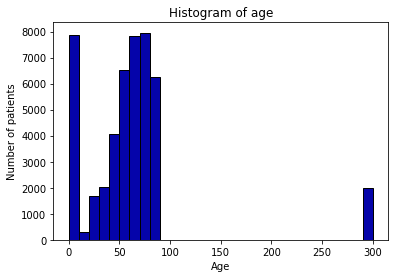

In [27]:

# matplotlib histogram
plt.hist(den['age'], color = '#0504aa', edgecolor = 'black',bins = int(300/10))


# Add labels
plt.title('Histogram of age')
plt.xlabel('Age')
plt.ylabel('Number of patients')



# b) Data Exploration: Distribution of patient heart rates

In [28]:
#PART B
denquery_b = \
"""
select valuenum as heart_rate from (
SELECT subject_id, valuenum, ROW_NUMBER() OVER (PARTITION BY subject_id) AS rn FROM chartevents ce 
inner join d_items  di on ce.itemid=di.itemid where lower(label) ='heart rate' 
)x where rn=1

"""

den_b = pd.read_sql_query(denquery_b,con)

Text(0, 0.5, 'number of patients')

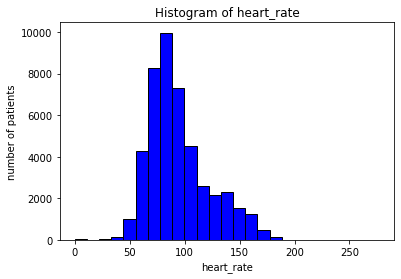

In [32]:

# matplotlib histogram
plt.hist(den_b['heart_rate'], color = 'blue', edgecolor = 'black',bins =25)


# Add labels
plt.title('Histogram of heart_rate')
plt.xlabel('heart_rate')
plt.ylabel('number of patients')


# c) Data Exploration: Scatter Plot of patients heart rate v/s age

In [33]:
#PART 3
#PART B
denquery_c = \
"""
select age,heart_rate from
(
select patient_id, age from 
(
SELECT p.subject_id as patient_id, MIN( ROUND( (cast(admittime as date) - cast(dob as date)) / 365.242,0) ) AS age 
FROM patients p
INNER JOIN admissions a
ON p.subject_id = a.subject_id 
GROUP BY p.subject_id 
ORDER BY p.subject_id 
)x where  (age>=0 and age<400)
)ag
inner join
(
select patient_id,ROUND(valuenum::numeric,0) as heart_rate from (
SELECT subject_id as patient_id, valuenum, ROW_NUMBER() OVER (PARTITION BY subject_id) AS rn FROM chartevents ce 
inner join d_items  di on ce.itemid=di.itemid where lower(label) ='heart rate'  
)x where rn=1 and (valuenum>=30 and valuenum<250)
)hr
on
ag.patient_id=hr.patient_id 
"""

den_c = pd.read_sql_query(denquery_c,con)



Text(0, 0.5, 'heart_rate')

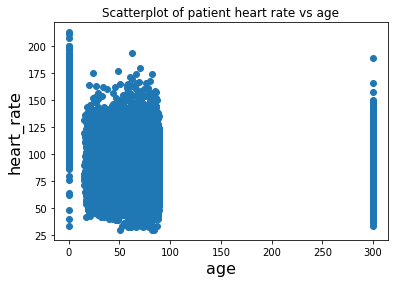

In [36]:

plt.scatter(den_c['age'],den_c['heart_rate'])
plt.title('Scatterplot of patient heart rate vs age')
plt.xlabel('age', fontsize=16)
plt.ylabel('heart_rate', fontsize=16)

